# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

## **Import**

In [1]:
import os
import numpy as np
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import wandb
from tqdm import tqdm
import copy

import torch
from torchvision.datasets import FakeData
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models.resnet import BasicBlock

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FakeData, CIFAR10


### ***Further settings***

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
SEED = 808
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

# ***Import Exercise1 ResCNN_Model architecture and weights***

In [3]:

class VariableDepthResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding):
        super().__init__()
        # Initial convolution + batch norm + activation
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)

        # Stack residual blocks
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(base_channels, base_channels))
        self.res_blocks = nn.Sequential(*layers)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout + final classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.res_blocks(x)                  
        x = self.pool(x)                       
        x = torch.flatten(x, 1)                  
        x = self.dropout(x)                     
        return self.fc(x)                        



#model istance
model = VariableDepthResNet(
    num_blocks=4,
    num_classes=10,
    base_channels=32,
    dropout_rate=0.2,
    in_channels=3,
    padding=1
).to(device)

state_dict = torch.load( r"models\best_model_ResCNN.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

C:\Users\emile\AppData\Local\Temp\ipykernel_16548\304565346.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load( r"models\best_model_ResCNN.pth", ma

VariableDepthResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

### **Load Data CIFAR-10**

In [4]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                         num_workers=8, persistent_workers=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                        num_workers=8, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


### **Load Fake dataset**

In [5]:

fakeset = FakeData(size=1000, image_size=(3,32,32), transform=transform)
fakeloader = DataLoader(fakeset, batch_size=128, shuffle=False)

### *Visualize a sample from FakeData*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


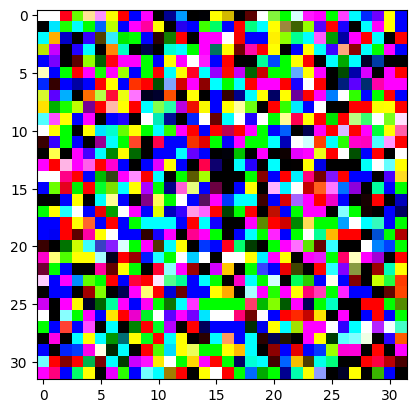

torch.Size([128, 3, 32, 32]) airplane


In [7]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0].permute(1, 2, 0))  # convert from (C,H,W) to (H,W,C)
    plt.show()
    break

print(x.shape, trainset.classes[y[80]])

## **scores function**

In [6]:
def get_max_softmax_scores(model, dataloader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            max_scores, _ = torch.max(probs, dim=1)
            scores.extend(max_scores.cpu().numpy())
    return np.array(scores)


## **Model evaluation**

Accuracy: 0.7705


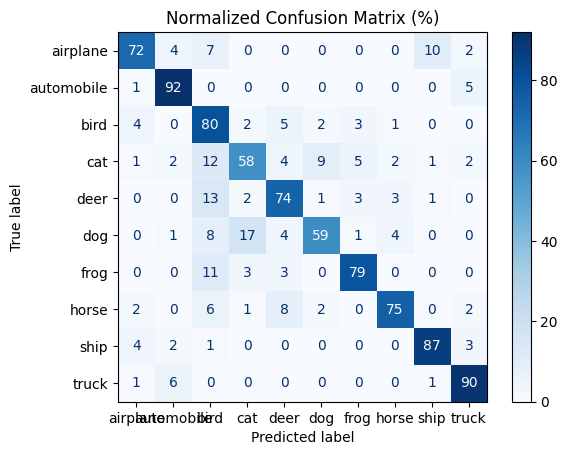

In [9]:
# Ensure the model is in evaluation mode
model.eval()
y_pred = []
y_gt = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predicted class
        preds = torch.argmax(outputs, dim=1)
        
    
        y_pred.append(preds.cpu())
        y_gt.append(labels.cpu())

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)
accuracy = metrics.accuracy_score(y_gt_t.numpy(), y_pred_t.numpy())
print(f'Accuracy: {accuracy:.4f}')

# Compute confusion matrix
cm = metrics.confusion_matrix(y_gt_t.numpy(), y_pred_t.numpy())
cmn = cm.astype(np.float32)
cmn /= cmn.sum(axis=1)[:, np.newaxis]
# Convert to percentages
cmn = (100 * cmn).astype(np.int32)

disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Normalized Confusion Matrix (%)")
plt.show()


### **Logits and Softmax plot for OOD and ID**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.96862745].


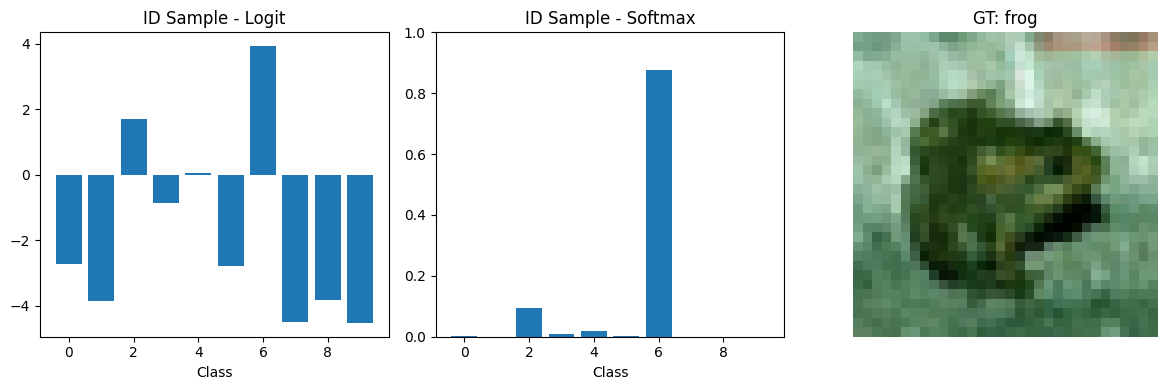

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


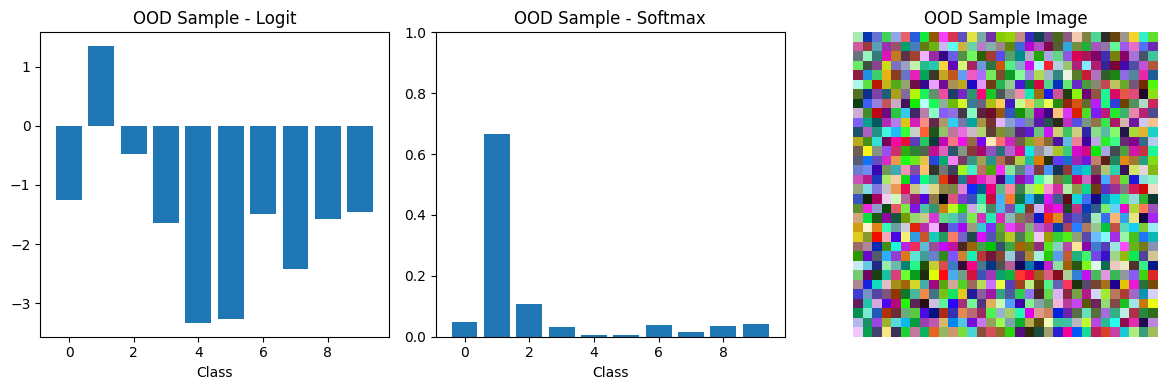

In [10]:
model.eval()
# Pick one random sample from ID dataset
x_id, y_id = next(iter(testloader))
k_id = random.randint(0, x_id.shape[0]-1)
x_id, y_id = x_id.to(device), y_id.to(device)

# Pick one random sample from OOD dataset
x_ood, _ = next(iter(fakeloader))
k_ood = random.randint(0, x_ood.shape[0]-1)
x_ood = x_ood.to(device)

 # Plots logit, softmax, and image for a single sample from a batch.
def plot_sample_logit_softmax_image(x_batch, k, title, y_batch=None, class_names=None):

    with torch.no_grad():
        output = model(x_batch)
    
    logits = output[k].detach().cpu()
    softmax_probs = F.softmax(output, dim=1)[k].detach().cpu()
    plt.figure(figsize=(12,4))
    
    # Logit plot
    plt.subplot(1,3,1)
    plt.bar(range(len(logits)), logits)
    plt.title(f'{title} - Logit')
    plt.xlabel('Class')
    # Softmax plot
    plt.subplot(1,3,2)
    plt.bar(range(len(softmax_probs)), softmax_probs)
    plt.title(f'{title} - Softmax')
    plt.ylim(0,1)
    plt.xlabel('Class')
    # Image
    plt.subplot(1,3,3)
    img = x_batch[k].cpu().permute(1,2,0)
    
    # Undo normalization for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std  = torch.tensor([0.2023, 0.1994, 0.2010])
    img = img * std + mean
    plt.imshow(img)
    if y_batch is not None and class_names is not None:
        plt.title(f'GT: {class_names[y_batch[k].cpu()]}')
    else:
        plt.title(f'{title} Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_logit_softmax_image(x_id, k_id, "ID Sample", y_id, testset.classes)
plot_sample_logit_softmax_image(x_ood, k_ood, "OOD Sample")


## ***overlapping histogram***

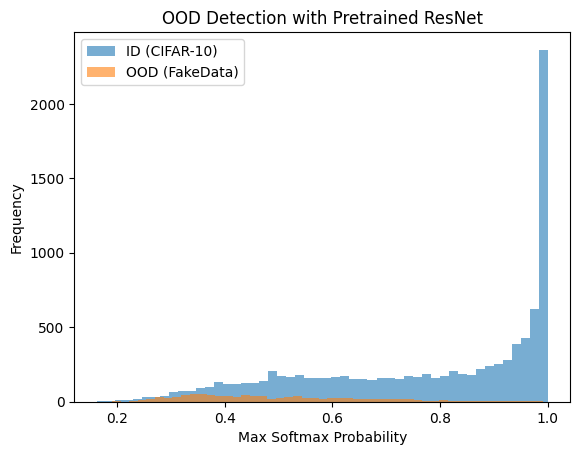

In [11]:
id_scores = get_max_softmax_scores(model, testloader, device)
ood_scores = get_max_softmax_scores(model, fakeloader, device)

#Plot scores
plt.hist(id_scores, bins=50, alpha=0.6, label="ID (CIFAR-10)")
plt.hist(ood_scores, bins=50, alpha=0.6, label="OOD (FakeData)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.legend()
plt.title("OOD Detection with Pretrained ResNet")
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



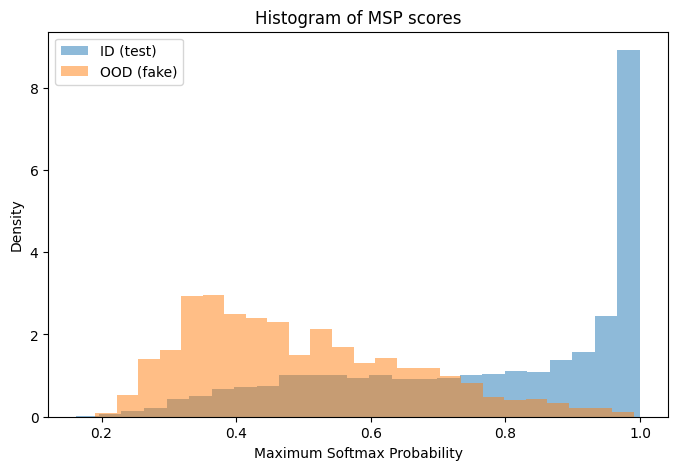


 ***Overlap area**= 0.4758



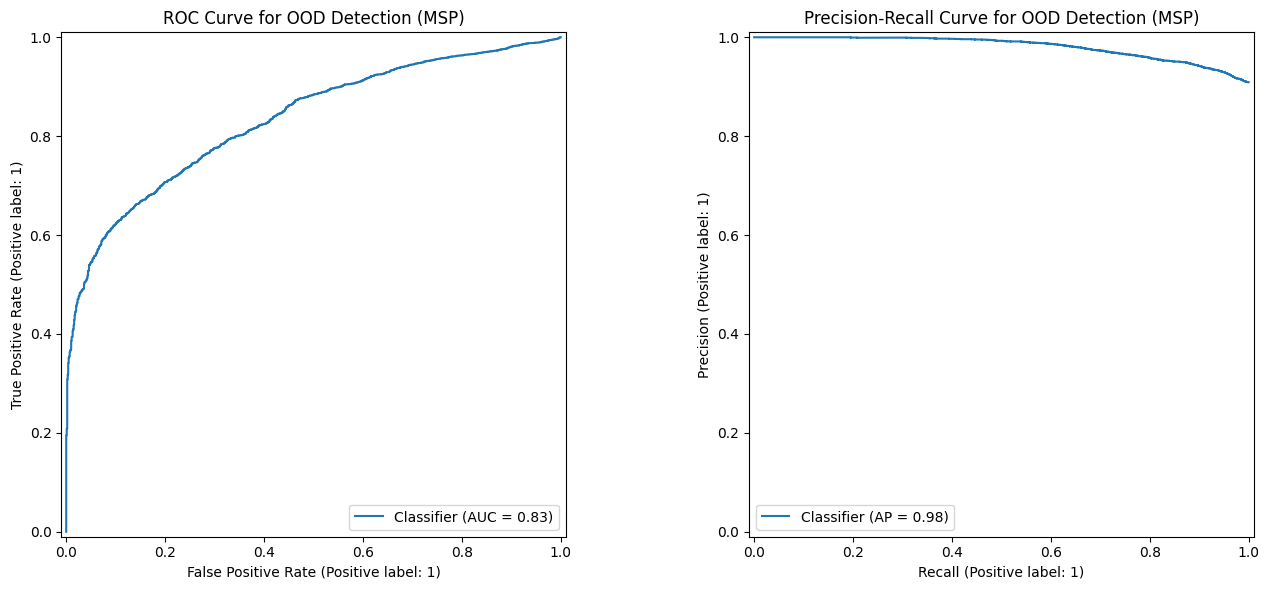

In [12]:
# Plot histograms with density
plt.figure(figsize=(8,5))
plt.hist(id_scores, density=True, alpha=0.5, bins=25, label='ID (test)')
plt.hist(ood_scores, density=True, alpha=0.5, bins=25, label='OOD (fake)')
plt.xlabel('Maximum Softmax Probability')
plt.ylabel('Density')
plt.title('Histogram of MSP scores')
plt.legend()
plt.show()

# Define common bins
bins = np.linspace(0, 1, 50)
# Compute histograms as probability densities
hist_id, _ = np.histogram(id_scores, bins=bins, density=True)
hist_ood, _ = np.histogram(ood_scores, bins=bins, density=True)

# Calculate the overlap area
bin_width = bins[1] - bins[0]
overlap_area = np.sum(np.minimum(hist_id, hist_ood)) * bin_width
print(f"\n ***Overlap area**= {overlap_area:.4f}\n")

# Prepare labels for ROC / PR
y_true = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
y_scores = np.concatenate([id_scores, ood_scores])

#Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_scores, ax=axes[0])
axes[0].set_title("ROC Curve for OOD Detection (MSP)")

# Precision-Recall Curve 
PrecisionRecallDisplay.from_predictions(y_true, y_scores, ax=axes[1])
axes[1].set_title("Precision-Recall Curve for OOD Detection (MSP)")

plt.tight_layout()
plt.show()


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

### **Class of dataset**

In [13]:
for i,c in enumerate(testset.classes):
    print(f"\n-{i}:{c}")


-0:airplane

-1:automobile

-2:bird

-3:cat

-4:deer

-5:dog

-6:frog

-7:horse

-8:ship

-9:truck


## ***FGSM implementation***

In [7]:
# Inverse normalization for visualization
class NormalizeInverse(transforms.Normalize):
    """Undo normalization for CIFAR-10 images."""
    def __init__(self, mean, std):
        mean, std = torch.as_tensor(mean), torch.as_tensor(std)
        super().__init__(mean=-mean/(std+1e-7), std=1/(std+1e-7))

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse(mean=(0.4914, 0.4822, 0.4465),
                       std=(0.2023, 0.1994, 0.2010))

# Single-step FGSM attack
def fgsm_attack(model, images, labels, epsilon=0.03, targeted=False, target_label=None):
    model.eval()
    images, labels = images.clone().detach().to(device), labels.to(device)
    images.requires_grad = True
    outputs = model(images)
    
    # Prepare target for loss
    if targeted:
        if target_label is None:
            raise ValueError("target_label must be specified for targeted attack")
        targets = torch.ones_like(labels) * target_label
    else:
        targets = labels
    
    loss = F.cross_entropy(outputs, targets)
    model.zero_grad()
    loss.backward()
    
    # FGSM update
    with torch.no_grad():
        if targeted:
            adv_images = images - epsilon * images.grad.sign() 
        else:
            adv_images = images + epsilon * images.grad.sign() 

    return adv_images.detach()


## **Examples of  UNTARGET attack**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.411605e-07..0.96470606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0060692383..0.9706881].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.050980162..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0449502..1.0060692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.411605e-07..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0059822346..1.0060692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ran

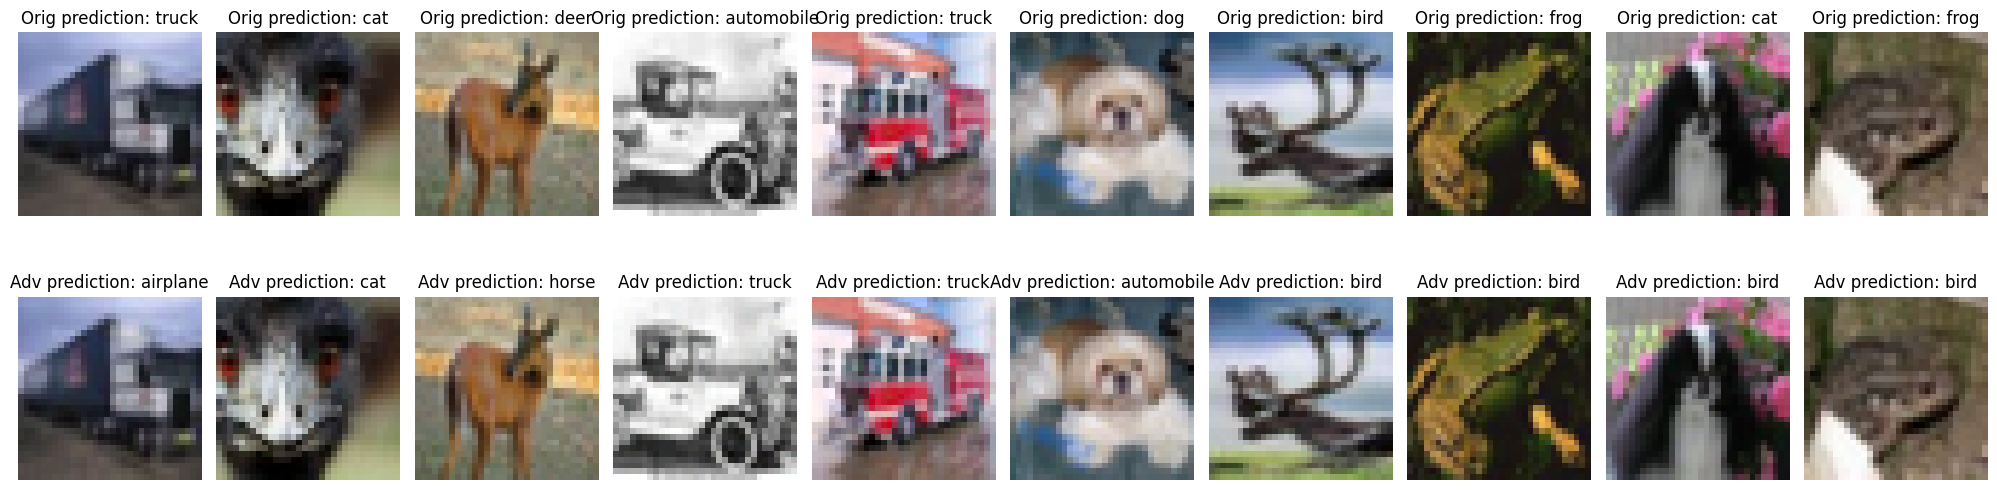

In [15]:
#FGSM attack on first batch
epsilon = 0.03
images, labels = next(iter(testloader))
adv_images = fgsm_attack(model, images, labels, epsilon)
model.eval()
with torch.no_grad():
    preds_orig = model(images.to(device)).argmax(dim=1)
    preds_adv = model(adv_images.to(device)).argmax(dim=1)

# Plot original vs adversarial
plt.figure(figsize=(20,6))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(inv(images[i+34]).permute(1,2,0).cpu())
    plt.title(f"Orig prediction: {testset.classes[preds_orig[i+34]]}")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(inv(adv_images[i+34].detach()).permute(1,2,0).cpu())
    plt.title(f"Adv prediction: {testset.classes[preds_adv[i+34]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


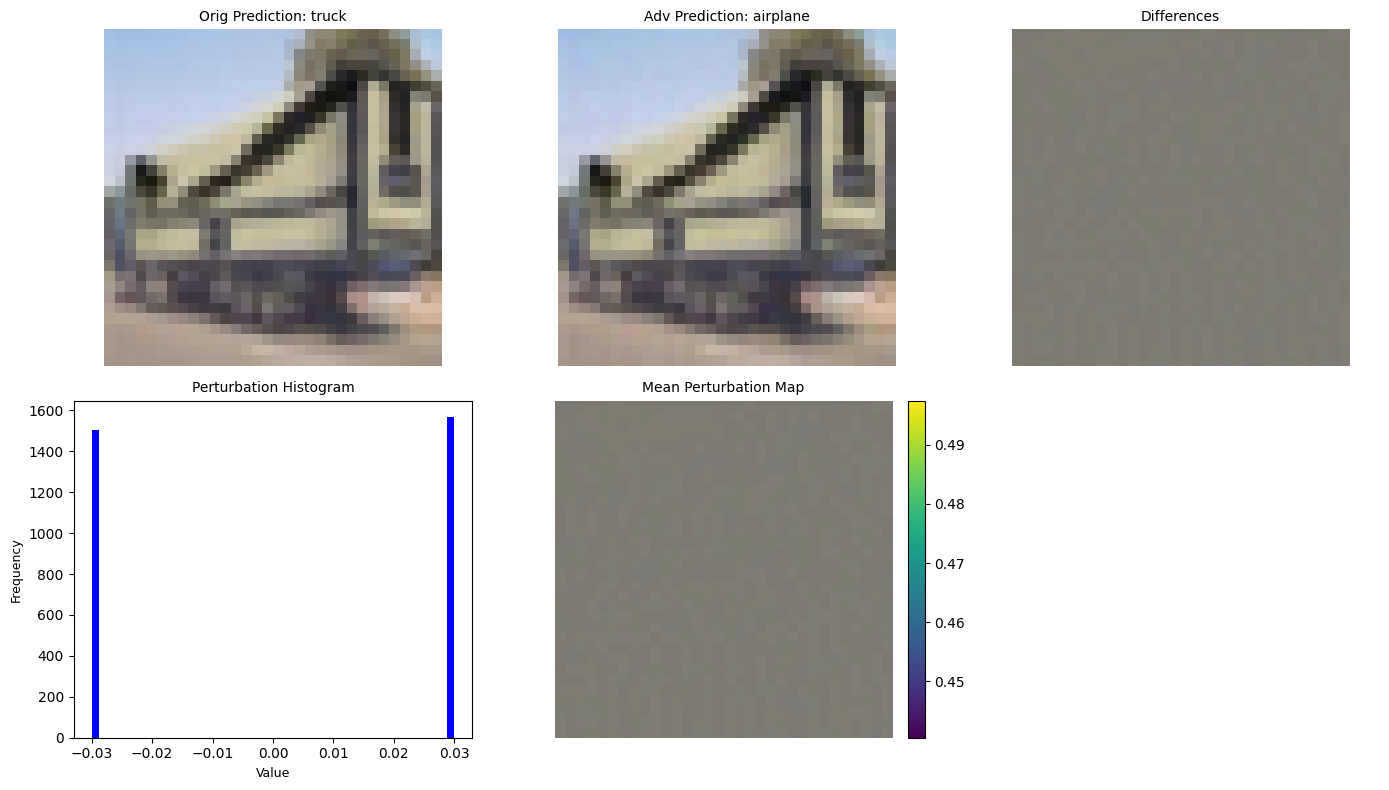

In [16]:
# Select one image from batch
idx = 76
img_orig = images[idx].unsqueeze(0).to(device)
img_adv = adv_images[idx].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    pred_orig = model(img_orig).argmax(dim=1).item()
    pred_adv = model(img_adv).argmax(dim=1).item()

# Move tensors to CPU and compute difference
img_orig_cpu = img_orig.cpu()
img_adv_cpu = img_adv.cpu()
diff = img_adv_cpu - img_orig_cpu
diff_flat = diff.flatten().detach().numpy()
diff_mean = diff.mean(0)

# Plots
fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes[0,0].imshow(inv(img_orig_cpu[0]).permute(1,2,0))
axes[0,0].set_title(f"Orig Prediction: {testset.classes[pred_orig]}", fontsize=10)
axes[0,0].axis('off')

axes[0,1].imshow(inv(img_adv_cpu[0].detach()).permute(1,2,0))
axes[0,1].set_title(f"Adv Prediction: {testset.classes[pred_adv]}", fontsize=10)
axes[0,1].axis('off')

axes[0,2].imshow(inv(diff[0].detach()).permute(1,2,0))
axes[0,2].set_title("Differences", fontsize=10)
axes[0,2].axis('off')

axes[1,0].hist(diff_flat, bins=50, color='blue')
axes[1,0].set_title("Perturbation Histogram", fontsize=10)
axes[1,0].set_xlabel("Value", fontsize=9)
axes[1,0].set_ylabel("Frequency", fontsize=9)

im = axes[1,1].imshow(inv(diff_mean).detach().permute(1,2,0))
axes[1,1].set_title("Mean Perturbation Map", fontsize=10)
axes[1,1].axis('off')
fig.colorbar(im, ax=axes[1,1], fraction=0.046, pad=0.04)

axes[1,2].axis('off')

plt.tight_layout()
plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

## ***Traning augmented on the fly and evaluation***

In [17]:

# CONFIGURATION
project_name = "fgsm_adversarial_training"
wandb.init(project=project_name)
wandb.config.update({
    "epochs": 40,
    "epsilon": 0.03,
    "batch_size": trainloader.batch_size,
    "learning_rate": 1e-3
})


#CREATE COPY FOR ADVERSARIAL TRAINING
model_advTrained = copy.deepcopy(model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_advTrained.parameters(), lr=wandb.config.learning_rate)
num_epochs = wandb.config.epochs
epsilon = wandb.config.epsilon
log_every = max(1, len(trainloader) // 1)

# TRAINING LOOP 
model_advTrained.train()
for epoch in range(num_epochs):
    y_true_orig, y_pred_orig = [], []
    y_true_adv, y_pred_adv = [], []

    loop = tqdm(enumerate(trainloader), total=len(trainloader),
                desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)

    for i, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model_advTrained(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true_orig.extend(labels.cpu().numpy())
        y_pred_orig.extend(outputs.argmax(dim=1).cpu().numpy())

        # On-the-fly adversarial augmentation
        images_adv = fgsm_attack(model_advTrained, images, labels, epsilon=epsilon, targeted=False)
        outputs_adv = model_advTrained(images_adv)
        loss_adv = criterion(outputs_adv, labels)
        optimizer.zero_grad()
        loss_adv.backward()
        optimizer.step()
        y_true_adv.extend(labels.cpu().numpy())
        y_pred_adv.extend(outputs_adv.argmax(dim=1).cpu().numpy())

        # Logging
        if (i+1) % log_every == 0 or i+1 == len(trainloader):
            metrics = {
                "epoch": epoch+1,
                "batch": i+1,
                "loss_orig": loss.item(),
                "loss_adv": loss_adv.item(),
                "acc_orig": accuracy_score(y_true_orig, y_pred_orig),
                "acc_adv": accuracy_score(y_true_adv, y_pred_adv)
            }
            wandb.log(metrics)
            loop.set_postfix(Acc_orig=f"{metrics['acc_orig']:.3f}",
                             Acc_adv=f"{metrics['acc_adv']:.3f}")

#EVALUATION FUNCTION
def evaluate(model, loader, is_adversarial=False, epsilon=None):
    model.eval()
    y_true, y_pred = [], []
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        if is_adversarial:
            # Generate the adversarial images. The fgsm_attack function handles the grad computation.
            imgs_adv = fgsm_attack(model, imgs, labels, epsilon=epsilon, targeted=False)
            
            # Now, evaluate the model on the adversarial images within a no_grad block
            with torch.no_grad():
                outputs = model(imgs_adv)
        else:
            with torch.no_grad():
                outputs = model(imgs)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average="macro")

#FINAL EVALUATION ON ADVERSARIAL TRAINED MODEL
acc_train_orig, f1_train_orig = evaluate(model_advTrained, trainloader)
acc_test_orig, f1_test_orig = evaluate(model_advTrained, testloader)
acc_train_adv, f1_train_adv = evaluate(model_advTrained, trainloader, is_adversarial=True, epsilon=epsilon)
acc_test_adv, f1_test_adv = evaluate(model_advTrained, testloader, is_adversarial=True, epsilon=epsilon)

print(f"\n Metrics on model_advTrained ORIGINAL images:")
print(f"Train Acc: {acc_train_orig:.4f}, F1: {f1_train_orig:.4f}")
print(f"Test Acc: {acc_test_orig:.4f}, F1: {f1_test_orig:.4f}")

print(f"\n Metrics on model_advTrained ADVERSARIAL images:")
print(f"Train Acc: {acc_train_adv:.4f}, F1: {f1_train_adv:.4f}")
print(f"Test Acc: {acc_test_adv:.4f}, F1: {f1_test_adv:.4f}")

torch.save(model_advTrained.state_dict(), "models/model_advTrained.pth")
print("Saved model_advTrained to models/model_advTrained.pth")

wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: emile-agbedanu (emile-agbedanu-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 40/40: 100%|█████████████████| 391/391 [01:40<00:00,  3.90it/s, Acc_adv=0.636, Acc_orig=0.834]



 Metrics on model_advTrained ORIGINAL images:
Train Acc: 0.8484, F1: 0.8463
Test Acc: 0.7915, F1: 0.7887

 Metrics on model_advTrained ADVERSARIAL images:
Train Acc: 0.6506, F1: 0.6455
Test Acc: 0.5995, F1: 0.5954
Saved model_advTrained to models/model_advTrained.pth


acc_adv,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
acc_orig,▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█████
batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_adv,█▅▆▄▅▅▅▄█▆▄▆▃▄▅▅▂▂▅▅▃▆▄▂▃▄▄▂▁▄▅▄▅▄▄▂▄▅▄▁
loss_orig,▇▅▆▄▅▆▅▅██▅▅▃▄▄▄▂▂▅▅▃▆▃▃▃▄▄▂▁▃▅▄▄▄▃▂▄▄▄▁
acc_adv,0.6358
acc_orig,0.83416
batch,391
epoch,40
loss_adv,0.81014


---
## Exercise 3: Wildcard
### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


## **Example of single Target attack**

Starting attack on a correctly classified image (ship) to target 'horse'.
Step 1, model predicts: ship
Step 2, model predicts: bird
Step 3, model predicts: horse
Target reached in 3 steps!


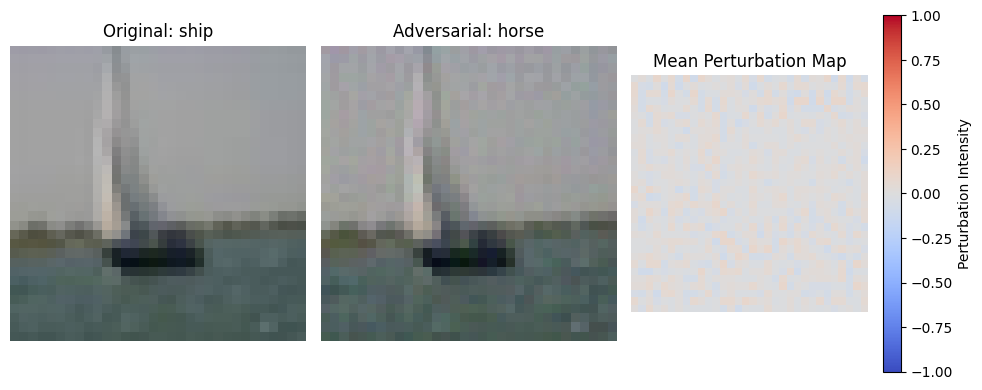

In [8]:
# Attack configuration
sample_id = 55
epsilon = 0.03
"""ATTACK TARGET"""
target_class_name = 'horse'

# Load one batch and select a single sample
images, labels = next(iter(testloader))
class_dict = {name: idx for idx, name in enumerate(testset.classes)}
target_label = class_dict[target_class_name]

x = images[sample_id].unsqueeze(0).to(device)  
y = labels[sample_id].unsqueeze(0).to(device)

# Ensure the model correctly classifies the original image
model.eval()
with torch.no_grad():
    pred_orig = model(x).argmax(dim=1).item()
if pred_orig != y.item():
    print(f"Skipping sample {sample_id}: model already misclassifies it as {testset.classes[pred_orig]}.")
else:
    print(f"Starting attack on a correctly classified image ({testset.classes[y.item()]}) to target '{target_class_name}'.")
    adv_img = x.clone() 
    done = False
    step = 0
    
    # Iterative attack loop
    while not done:
        step += 1
        adv_img = fgsm_attack(model, adv_img, y, epsilon=epsilon, targeted=True, target_label=target_label)
        pred = model(adv_img).argmax(dim=1).item()
        print(f"Step {step}, model predicts: {testset.classes[pred]}")
        if pred == target_label:
            print(f"Target reached in {step} steps!")
            done = True

        # Safety exit to prevent infinite loops
        if step > 5:
            print("Maximum steps reached. Attack failed.")
            done = True
    
    # Plots
    diff = adv_img - x
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,3,1)
    plt.imshow(inv(x[0]).permute(1,2,0).cpu().detach())
    plt.title(f"Original: {testset.classes[y.item()]}")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(inv(adv_img[0]).permute(1,2,0).cpu())
    plt.title(f"Adversarial: {testset.classes[pred]}")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(diff.squeeze().mean(dim=0).cpu().detach(), cmap='coolwarm',vmin=-1, vmax=1)
    plt.colorbar(label="Perturbation Intensity")
    plt.title("Mean Perturbation Map")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

### **Target attack and mmetric valutation**

Skipping sample 6 (already misclassified).
Skipping sample 8 (already misclassified).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07450962..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06847962..1.0060303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686044..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.009617046..1.0060303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.396108e-07..0.737255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0060302373..0.73118603].



--- Quantitative Evaluation on whole batch ---
Targeted Success Rate: **61.39%**
Average confidence increase for target class: **0.4077**
Average perturbation L2 norm: **1.6628**



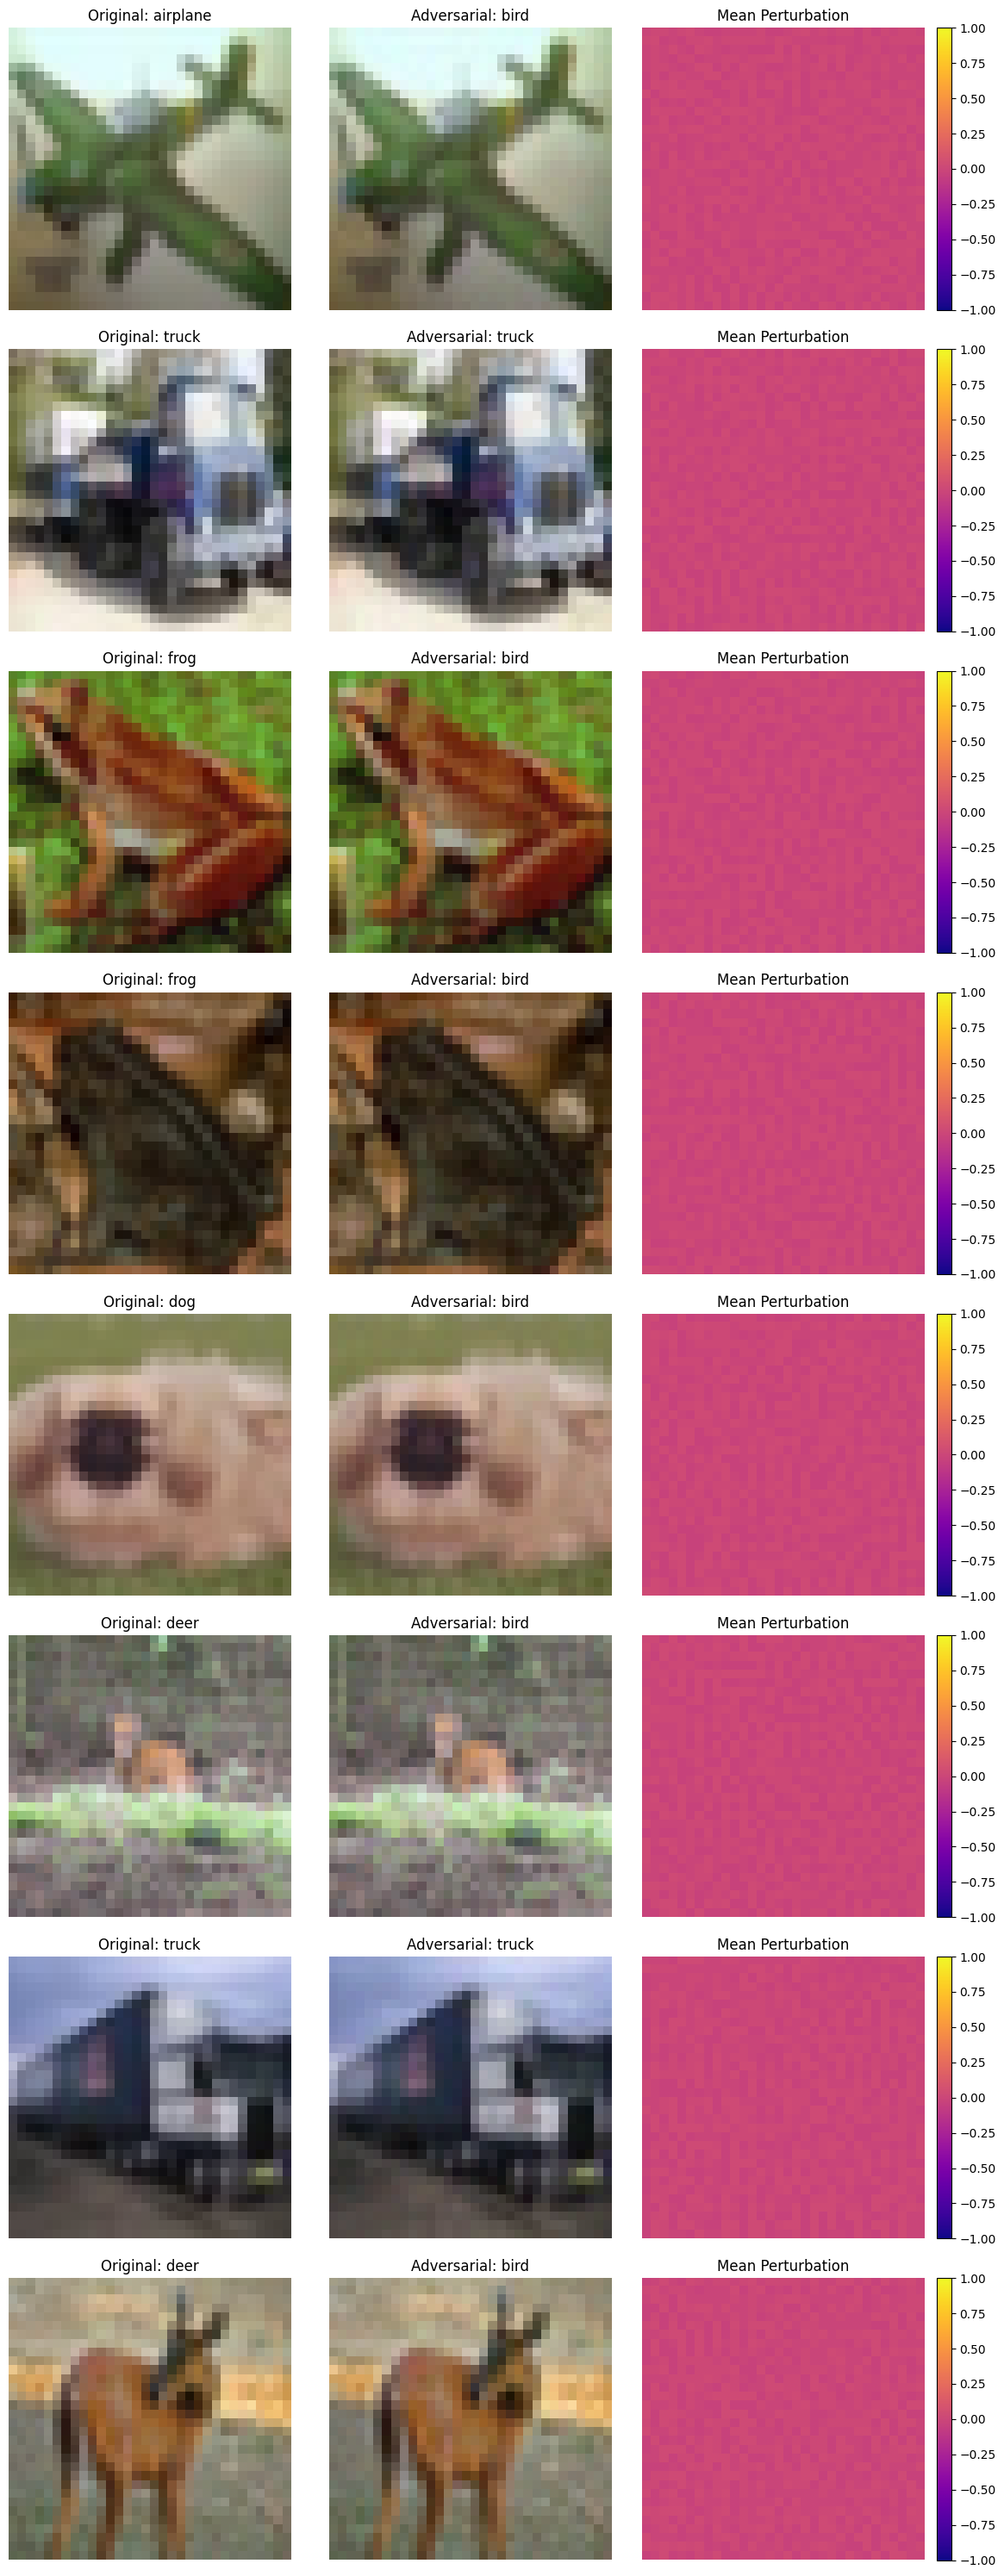

In [11]:
""""ATTACK TARGET"""
target_class_name = 'bird'
n_examples = 10
epsilon = 0.03

class_dict = {name: idx for idx, name in enumerate(testset.classes)}
target_label = class_dict[target_class_name]

# Take first batch from testloader
images, labels = next(iter(testloader))
images, labels = images.to(device), labels.to(device)

adv_images_list = []
y_pred_before = []
y_pred_after = []
target_conf_before = []
target_conf_after = []
perturb_norms = []

model.eval()
for i in range(n_examples):
    x = images[i+27].unsqueeze(0)
    y = labels[i+27].unsqueeze(0)

    # Skip misclassified samples
    with torch.no_grad():
        pred_orig = model(x).argmax(dim=1).item()
    if pred_orig != y.item():
        print(f"Skipping sample {i} (already misclassified).")
        continue

    adv_x = fgsm_attack(model, x, y, epsilon=epsilon, targeted=True, target_label=target_label)

    with torch.no_grad():
        out_before = model(x)
        out_after = model(adv_x)

    y_pred_before.append(out_before.argmax(dim=1).item())
    y_pred_after.append(out_after.argmax(dim=1).item())

    # Confidence for target class
    target_conf_before.append(F.softmax(out_before, dim=1)[0, target_label].item())
    target_conf_after.append(F.softmax(out_after, dim=1)[0, target_label].item())

    # Perturbation magnitude (L2 norm)
    perturb_norms.append((adv_x - x).norm(p=2).item())

    adv_images_list.append((x, adv_x, y.item(), out_after.argmax(dim=1).item()))

# Quantitative metrics on the entire batch
y_pred_before_batch = []
y_pred_after_batch = []
target_conf_before_batch = []
target_conf_after_batch = []
perturb_norms_batch = []

for idx in range(len(images)):
    x = images[idx].unsqueeze(0)
    y = labels[idx].unsqueeze(0)

    # Skip samples that are already misclassified
    with torch.no_grad():
        pred_orig = model(x).argmax(dim=1).item()
    if pred_orig != y.item():
        continue

    # Generate targeted adversarial example
    adv_x = fgsm_attack(model, x, y, epsilon=epsilon, targeted=True, target_label=target_label)

    with torch.no_grad():
        out_before = model(x)
        out_after = model(adv_x)

    # Record predictions
    y_pred_before_batch.append(out_before.argmax(dim=1).item())
    y_pred_after_batch.append(out_after.argmax(dim=1).item())

    # Record confidence for target class
    target_conf_before_batch.append(F.softmax(out_before, dim=1)[0, target_label].item())
    target_conf_after_batch.append(F.softmax(out_after, dim=1)[0, target_label].item())

    # Record L2 norm of perturbation
    perturb_norms_batch.append((adv_x - x).norm(p=2).item())

# Compute metrics on the entire batch
success_rate = sum(1 for pred in y_pred_after_batch if pred == target_label) / len(y_pred_after_batch)
avg_conf_increase = (torch.tensor(target_conf_after_batch) - torch.tensor(target_conf_before_batch)).mean().item()
avg_perturb = sum(perturb_norms_batch) / len(perturb_norms_batch)

print(f"\n--- Quantitative Evaluation on whole batch ---")
print(f"Targeted Success Rate: **{success_rate*100:.2f}%**")
print(f"Average confidence increase for target class: **{avg_conf_increase:.4f}**")
print(f"Average perturbation L2 norm: **{avg_perturb:.4f}**\n")

#  Qualitative plots 
plt.figure(figsize=(12, n_examples*3))
for idx, (orig_img, adv_img, orig_label, adv_label) in enumerate(adv_images_list):
    diff = adv_img - orig_img

    plt.subplot(len(adv_images_list), 3, idx*3 + 1)
    plt.imshow(inv(orig_img[0]).permute(1, 2, 0).cpu())
    plt.title(f"Original: {testset.classes[orig_label]}")
    plt.axis('off')

    plt.subplot(len(adv_images_list), 3, idx*3 + 2)
    plt.imshow(inv(adv_img[0]).permute(1, 2, 0).cpu())
    plt.title(f"Adversarial: {testset.classes[adv_label]}")
    plt.axis('off')

    plt.subplot(len(adv_images_list), 3, idx*3 + 3)
    plt.imshow(diff.squeeze(0).mean(dim=0).cpu().numpy(), cmap='plasma', vmin=-1, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Mean Perturbation")
    plt.axis('off')

plt.tight_layout()
plt.show()
